# iterative closest point 

The ICP algorithm involves 3 steps: association, transformation, and error evaluation. These are repeated until the scans are aligned satisfactorily. The goal is to find the rigid transformation (rotation and translation) that best aligns the source to the target.

In [232]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

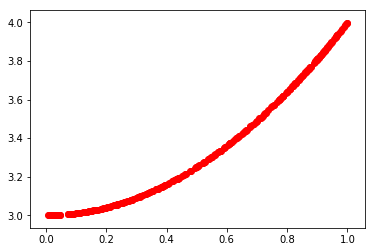

In [233]:
# Cria um núvem de pontos em formato de parabola

N = 300
sx = np.random.rand(N)
sy = []
sz = np.ones(N)
for i in range(N):
    sy.append(sx[i]**2 + 3)

source = np.array([sx, sy, sz])
plt.scatter(source[0], source[1], color = 'r', label = 'source')
plt.show()


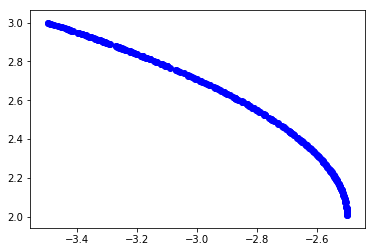

In [234]:
motion = [0.5, 2.0, np.deg2rad(90)]

t = np.identity(3, dtype=np.float64)

t[:2,2] = motion[0], motion[1]
t[:2,:2] = [[np.cos(motion[2]), -np.sin(motion[2])], [np.sin(motion[2]), np.cos(motion[2])]]

target = np.dot(t, source)

plt.scatter(target[0], target[1], color = 'b', label = 'target')
plt.show()


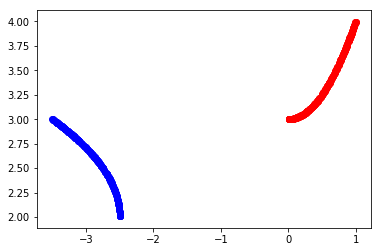

In [235]:
plt.scatter(source[0], source[1], color = 'r', label = 'source')
plt.scatter(target[0], target[1], color = 'b', label = 'target')
plt.show()

In [236]:
def icp(A, B, init_pose=None, max_iterations=50, tolerance=0.001):
    '''
    The Iterative Closest Point method
    Input:
        A: Nx3 numpy array of source 3D points
        B: Nx3 numpy array of destination 3D point
        init_pose: 4x4 homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation
        distances: Euclidean distances (errors) of the nearest neighbor
    '''

    # make points homogeneous, copy them so as to maintain the originals
    src = np.ones((4,A.shape[0]))  #(4, A.shape[0])
    dst = np.ones((4,B.shape[0]))
    src[0:3,:] = np.copy(A.T)  # A.T shape (3,20)
    dst[0:3,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbours between the current source and destination points
        distances, indices = nearest_neighbor(src[0:3,:].T, dst[0:3,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[0:3,:].T, dst[0:3,indices].T)  

        # update the current source
    # refer to "Introduction to Robotics" Chapter2 P28. Spatial description and transformations
        src = np.dot(T, src)

        # check error
        mean_error = np.sum(distances) / distances.size
        if abs(prev_error-mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculcate final tranformation
    T,R,t = best_fit_transform(A, src[0:3,:].T)
    
    T = np.identity(3)
    T[:2,:2] = R[:2,:2]
    T[:2,2] = t[:2]
    
    return T, distances

In [237]:
def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nx3 array of points
        dst: Nx3 array of points
    Output:
        distances: Euclidean distances (errors) of the nearest neighbor
        indecies: dst indecies of the nearest neighbor
    '''
    target_tree = KDTree(dst[:, :2])
    
    matched_src_pts = src[:, :2]

    distances, indecies = target_tree.query(matched_src_pts)
       
#     indecies = np.zeros(src.shape[0], dtype=np.int)
#     distances = np.zeros(src.shape[0])
#     for i, s in enumerate(src):
#         min_dist = np.inf
#         for j, d in enumerate(dst):
#             dist = np.linalg.norm(s-d)
#             if dist < min_dist:
#                 min_dist = dist
#                 indecies[i] = j
#                 distances[i] = dist

    return distances, indecies

In [238]:
def best_fit_transform(A, B):
    
    '''
    Calculates the least-squares best-fit transform between corresponding 3D points A-> B
    Input:
      A: Nx3 numpy array of corresponding 3D points
      B: Nx3 numpy array of corresponding 3D point2
    Returns:
      T: 4x4 homogeneous transformation matrix
      R: 3x3 rotation matrix
      t: 3x1 column vector
    '''

    assert len(A) == len(B)

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    W = np.dot(BB.T, AA)
    U, s, VT = np.linalg.svd(W, full_matrices=True, compute_uv=True)
    R = np.dot(U, VT)

    # special reflection case
    if np.linalg.det(R) < 0:
        VT[2,:] *= -1
        R = np.dot(U, VT)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(4)
    T[0:3, 0:3] = R
    T[0:3, 3] = t

    return T, R, t

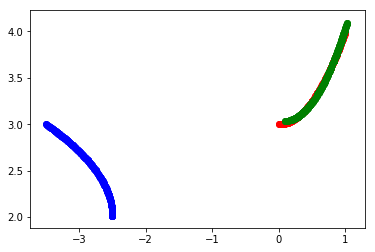

In [239]:
if __name__ == "__main__":
    
    T, distances = icp(source.T, target.T)
    result = np.dot(np.linalg.inv(T), target)
    plt.scatter(source[0], source[1], color = 'r', label = 'source')
    plt.scatter(target[0], target[1], color = 'b', label = 'target')
    plt.scatter(result[0], result[1], color = 'g', label = 'result')
    plt.show()